In [1]:
from util import ORIGINAL_PHOSPHOPEDIA_STATISTICS
from util.containers import *
from util.plotting import *

## Intro:

Adding additional data to the Phosphopedia database should increase the amount of information within it. However, the size of that increase is strongly determined by the amount of information in each additional PSM. Here, I will look at how much information was added, and compare the results of the new pipeline to those obtained with the orginal pipeline on the original data.

## Comparing the number of total matches and detections

In [2]:
%time original_build = DatabaseBuild("data/builds/human_phospho/original_20210907/phosphopedia.db")
%time updated_build = DatabaseBuild("data/builds/human_phospho/update_20210902/phosphopedia.db")

Loading PSMs...
Loading Peptides...
Loading Phosphosites
CPU times: user 17.6 s, sys: 1.82 s, total: 19.4 s
Wall time: 12min 42s
Loading PSMs...
Loading Peptides...
Loading Phosphosites
CPU times: user 1min 9s, sys: 4.97 s, total: 1min 14s
Wall time: 16min 39s


In [3]:
ORIGINAL_PHOSPHOPEDIA_STATISTICS

{'psms': 7577952, 'peptides': 191418, 'sites': 103460}

In [4]:
original_counts = {"psms" : original_build.psms.shape[0],
                   "peptides" : original_build.peptides.shape[0],
                   "sites" : original_build.sites.shape[0]}

original_counts

{'psms': 6309238, 'peptides': 193906, 'sites': 94934}

In [5]:
updated_counts = {"psms" : updated_build.psms.shape[0],
                  "peptides" : updated_build.peptides.shape[0],
                  "sites" : updated_build.sites.shape[0]}

updated_counts

{'psms': 25528379, 'peptides': 259745, 'sites': 116937}

In [6]:
count_df = pd.DataFrame.from_records([ORIGINAL_PHOSPHOPEDIA_STATISTICS,
                                      original_counts,
                                      updated_counts])
count_df["dataset"] = ["Original", "Re-analysis", "Update"]

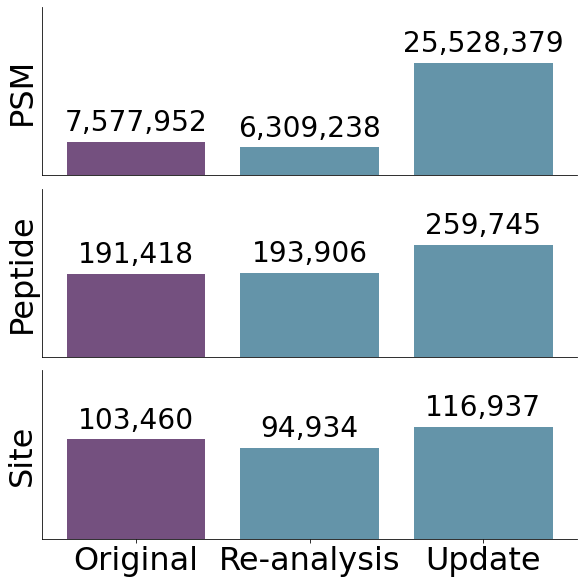

In [7]:
fig = plt.figure(figsize = [8, 8], 
                 constrained_layout=True)
gs = fig.add_gridspec(3, 1)

colors = ["#461554", "#30708d", "#30708d"]

for ind, name in enumerate(count_df.columns[:-1]):
    ax = fig.add_subplot(gs[ind, :])
    ax.bar(count_df.dataset,
           count_df[name],
           color = colors,
           alpha = .75)
    
    [ax.text(x, y, ",".join([str(v)[0:-6], str(v)[-6:-3], str(v)[-3:]]).lstrip(","),
             size=28, ha="center")
     for x,y,v in zip(count_df.dataset,
                      count_df[name] + .1 * count_df[name].max(),
                      count_df[name])]
    
    ax.set_ylim(0, count_df[name].max() * 1.5)
    ax.set_yticks([])
    ax.set_ylabel(dict(psms="PSM", peptides="Peptide", sites="Site")[name], size=32)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if ind < 2 :
        ax.set_xticks([])
    else:
        ax.tick_params(labelsize=32)
        

plt.savefig("figures/database_psm_and_detection_counts.svg")
plt.show()

Both the new and old pipeline generate a similar number of matches and detections from the old data. Most of the differences can easily be explained by differences in stringency. The new pipeline tends to be more stringent at the level of PSMs, and thus has a decrease. The old pipeline did not control site discoveries at a 1% FDR, so many of the detections are likely false positives. Interestingly, with the addition of new data, we do get a large increase in the number of PSMs in the database, but this does not translate into a large increase in detections at the peptide and site level. This is likely due to the mass spec reanalyzing peptides over and over again in new datasets. I will begin to look at that phenomena below.

## Comparing the increase in PSMs with the addition of new data.

In [8]:
def count_matches_per_peptide(build):
    counts = build.peptides.loc[:, ["id", "sequence"]]\
              .join(build.psms.set_index("pep_id").id,
                    on="id", how="left", rsuffix="_psm")\
              .groupby("sequence")\
              .id_psm\
              .count()\
              .rename("psm_count")
    
    return counts.reset_index()

In [9]:
original_build_count = count_matches_per_peptide(original_build)
updated_build_count = count_matches_per_peptide(updated_build)

In [10]:
joined_counts = original_build_count.join(updated_build_count.set_index("sequence"),
                                          how="outer", on="sequence",
                                          lsuffix="_original",
                                          rsuffix="_updated")\
                                    .fillna(0.)

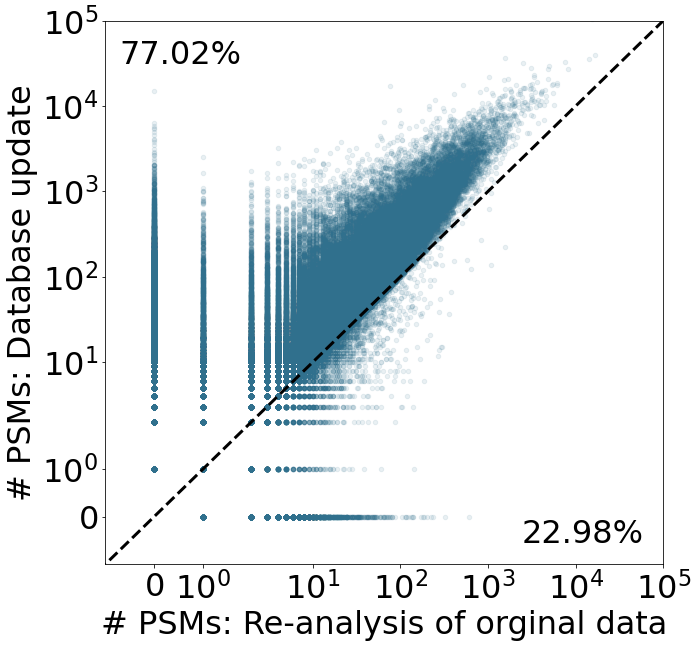

In [11]:
plt.figure(figsize=(10, 10))

plt.plot([-10, 1e5], [-10, 1e5], lw = 3, linestyle="--", c="black")
plt.scatter(joined_counts.psm_count_original, 
            joined_counts.psm_count_updated,
            c="#30708d", alpha=.1, s=20)

improved = joined_counts.psm_count_updated > joined_counts.psm_count_original
plt.text(-0.7, 6e4, 
         "{:.2f}%".format(
             100*np.sum(improved)/improved.shape[0]
             ),
         size=32,
         ha="left",
         va="top")
plt.text(6e4, -0.7, 
         "{:.2f}%".format(
             100*np.sum(~improved)/improved.shape[0]
             ),
         size=32,
         ha="right",
         va="bottom")

plt.xscale("symlog")
plt.xlim(-1, 1e5)
plt.yscale("symlog")
plt.ylim(-1, 1e5)

plt.tick_params(labelsize=32)
plt.xlabel("# PSMs: Re-analysis of orginal data", size=32)
plt.ylabel("# PSMs: Database update", size=32)

plt.savefig("figures/matches_per_peptide_update_vs_reanalysis.svg")
plt.show()

It is clear that per peptide, we are getting a massive increase in the number of PSMs. This is one thing that we hope for, because the number of PSMs per peptide directly corresponds to how good our predictions of charge affinity and how good our spectral libraries can be.